#Prédire les tendances du marché boursier à l'aide de Machine Learning

#Importation

In [158]:
!pip install yfinance
import yfinance as yf
import numpy as np
import scipy.stats as stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as optimize
from scipy.stats import gaussian_kde
import statsmodels.api as sm
from scipy import integrate
from sklearn.neighbors import KernelDensity
from statsmodels.nonparametric.bandwidths import bw_silverman, bw_scott, select_bandwidth
from scipy.stats import iqr
from pylab import rcParams
from tensorflow import keras
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.metrics import classification_report
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
import joblib
from keras.models import load_model
import seaborn as sns
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import grangercausalitytests
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import time

#Approche par régression temporelle

##Télechargement des données

In [ ]:
symbol = 'AAPL'
start_date = '2020-01-01'
end_date = '2022-12-31'

# Téléchargement des données depuis Yahoo Finance
data = yf.download(symbol, start=start_date, end=end_date)

data = data.dropna()

print(data.head())

# Affichage du nombre de lignes et de colonnes
print(f"Nombre de lignes : {data.shape[0]}")
print(f"Nombre de colonnes : {data.shape[1]}")

##Calcul des rendements quotidients

In [121]:
# Calculer le rendement quotidien
data['Daily_Return'] = (data['Close'] - data['Open']) / data['Open']*100
returns = data['Daily_Return'].values

##Estimation de la densité initiale

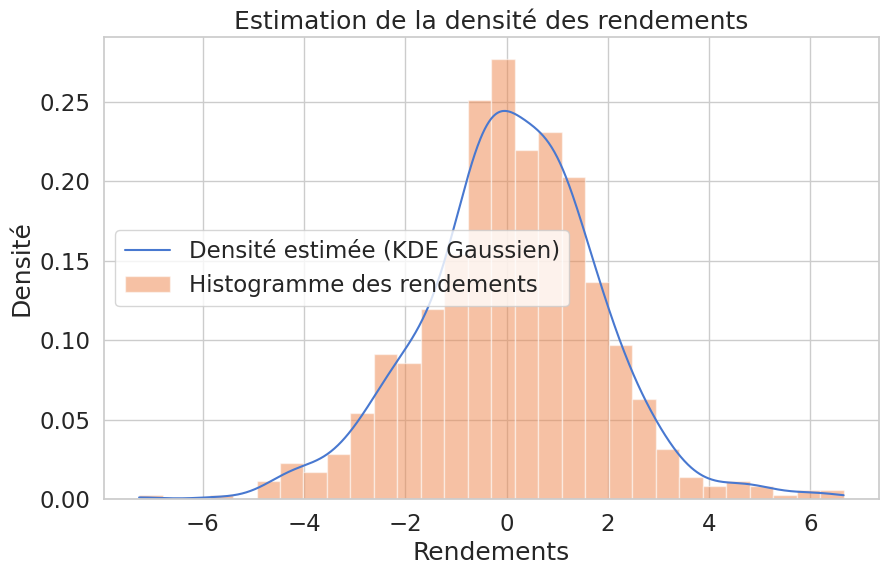

In [122]:
# Estimation de la densité par noyau
kernel = stats.gaussian_kde(returns)

x = np.linspace(min(returns), max(returns), 1000)

# Calculer les valeurs de densité pour chaque point
density_values = kernel.evaluate(x)

# Tracer la distribution estimée
plt.figure(figsize=(10, 6))
plt.plot(x, density_values, label="Densité estimée (KDE Gaussien)")
plt.hist(returns, bins=30, density=True, alpha=0.5, label="Histogramme des rendements")
plt.xlabel('Rendements')
plt.ylabel('Densité')
plt.title('Estimation de la densité des rendements')
plt.legend()
plt.show()

##AMISE

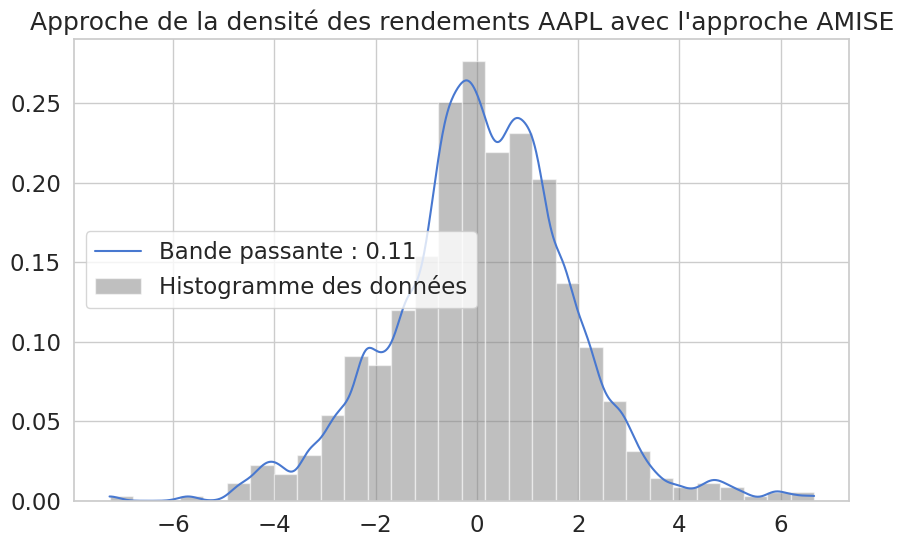

In [123]:
bandwidths = [0.11]
plt.figure(figsize=(10, 6))
for bw in bandwidths:
    kde = gaussian_kde(returns, bw_method=bw)
    plt.plot(x, kde.evaluate(x), label=f"Bande passante : {bw}")

plt.hist(returns, bins=30, density=True, alpha=0.5, label="Histogramme des données", color="grey")
plt.legend()
plt.title("Approche de la densité des rendements AAPL avec l'approche AMISE")
plt.show()

Objectifs : Développer un modèle qui prédit si le cours des actions d'une entreprise va augmenter ou baisser sur la base de données historiques.

Problématique : Classification binaire (prédire si le cours de l'action va monter ou descendre).

#I. Collection & Analyse des données

##Étape 1: Récupération des Données

 Rassemblage des données historiques sur les cours des actions et des fonctionnalités supplémentaires (indicateurs économiques, sentiment de l'actualité).

In [124]:
# Récupération des données financières pour Apple (AAPL) sur une période spécifique
symbol = 'AAPL'
start_date = '2020-01-01'
end_date = '2022-12-31'

# Téléchargement des données depuis Yahoo Finance
data = yf.download(symbol, start=start_date, end=end_date)


[*********************100%%**********************]  1 of 1 completed


In [125]:
# Affichage des premières lignes des données pour visualiser la collecte
print("Aperçu des données collectées :")
print(data.head())


Aperçu des données collectées :
                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2020-01-02  74.059998  75.150002  73.797501  75.087502  73.152664  135480400
2020-01-03  74.287498  75.144997  74.125000  74.357498  72.441467  146322800
2020-01-06  73.447502  74.989998  73.187500  74.949997  73.018669  118387200
2020-01-07  74.959999  75.224998  74.370003  74.597504  72.675293  108872000
2020-01-08  74.290001  76.110001  74.290001  75.797501  73.844353  132079200


##Étape 2: Prétraitement des Données

Normalisation des données, gestion des valeurs manquantes et création des fonctionnalités de décalage pour capturer les tendances historiques.

In [126]:
# Remplissage des valeurs manquantes
data.fillna(method='ffill', inplace=True)

# Sélection des colonnes pour la normalisation
columns_to_scale = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

# Normalisation des données
scaler = MinMaxScaler()
data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

# Affichage des données prétraitées
print(data.head())


                Open      High       Low     Close  Adj Close    Volume
Date                                                                   
2020-01-02  0.135658  0.143266  0.163891  0.150853   0.146799  0.256276
2020-01-03  0.137469  0.143226  0.166491  0.145055   0.141117  0.283984
2020-01-06  0.130782  0.141994  0.159049  0.149761   0.145729  0.212595
2020-01-07  0.142823  0.143862  0.168436  0.146961   0.142985  0.188279
2020-01-08  0.137489  0.150896  0.167801  0.156491   0.152325  0.247584


[*********************100%%**********************]  1 of 1 completed


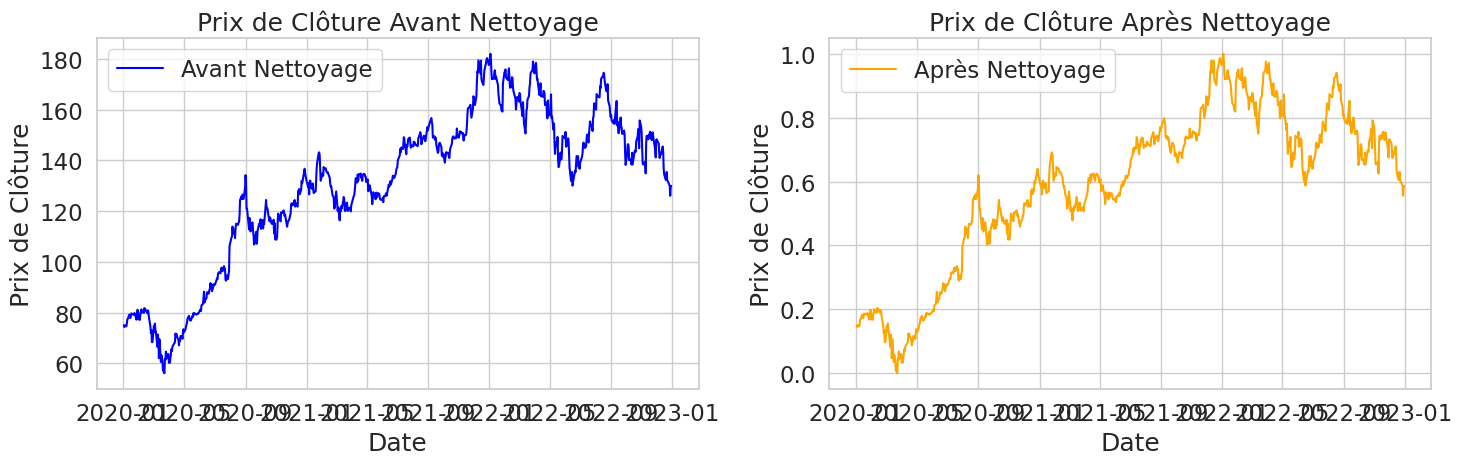

In [128]:
# Téléchargement des données
data_before_cleaning = yf.download(symbol, start='2020-01-01', end = '2022-12-31')

# Prétraitement des données (exemple simple)
data_after_cleaning = data

# Création de deux graphiques côte à côte
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Graphique Avant Nettoyage
axes[0].plot(data_before_cleaning['Close'], label='Avant Nettoyage', color='blue')
axes[0].set_title('Prix de Clôture Avant Nettoyage')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Prix de Clôture')
axes[0].legend()

# Graphique Après Nettoyage
axes[1].plot(data_after_cleaning['Close'], label='Après Nettoyage', color='orange')
axes[1].set_title('Prix de Clôture Après Nettoyage')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Prix de Clôture')
axes[1].legend()

plt.tight_layout()
plt.show()



###Préambule : analyse statique


In [156]:
# Utilisation du prix de clôture
data['Price_Yesterday'] = data['Close'].shift(1)
data = data.dropna()  # Supprimer les lignes avec des valeurs NaN

# Calcul de la corrélation de Pearson
correlation, p_value = pearsonr(data['Price_Yesterday'], data['Close'])
print(f"Corrélation de Pearson: {correlation}, P-value: {p_value}")

# Test de causalité de Granger
gc_test = grangercausalitytests(data[['Close', 'Price_Yesterday']], maxlag=2, verbose=True)


Corrélation de Pearson: 0.9912502676727966, P-value: 3.1364980185754745e-197

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4012  , p=0.2378  , df_denom=220, df_num=1
ssr based chi2 test:   chi2=1.4203  , p=0.2334  , df=1
likelihood ratio test: chi2=1.4158  , p=0.2341  , df=1
parameter F test:         F=1.4012  , p=0.2378  , df_denom=220, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1132  , p=0.8930  , df_denom=218, df_num=2
ssr based chi2 test:   chi2=0.2306  , p=0.8911  , df=2
likelihood ratio test: chi2=0.2305  , p=0.8911  , df=2
parameter F test:         F=0.9269  , p=0.3973  , df_denom=218, df_num=2


<ipython-input-156-d2fb279f8884>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Price_Yesterday'] = data['Close'].shift(1)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [155]:
data.head()

,Open,High,Low,Close,Adj Close,Volume,Target,Price_Yesterday
Date,,,,,,,,
2023-01-04,0.012530,0.012631,0.012797,0.018760,0.018611,0.499315,0,0.000700
2023-01-05,0.015948,0.000000,0.008297,0.000000,0.000000,0.436765,1,0.018760
2023-01-06,0.000000,0.035765,0.010125,0.064399,0.063887,0.488887,1,0.000000
2023-01-09,0.063506,0.080046,0.080439,0.071819,0.071248,0.358705,1,0.064399
2023-01-10,0.060515,0.049532,0.055548,0.079938,0.079303,0.305795,1,0.071819


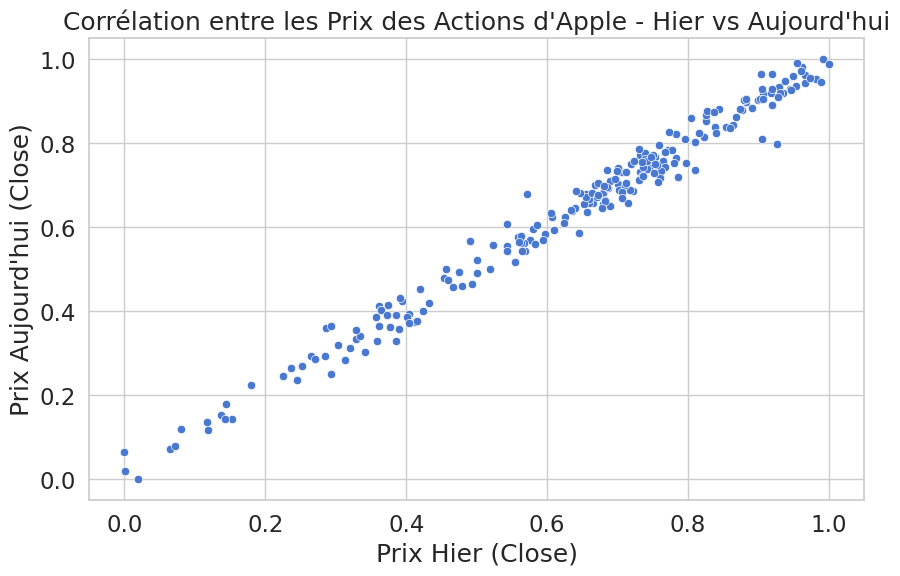

In [154]:
# Création du graphique de corrélation
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Price_Yesterday', y='Close', data=data)
plt.title(f'Corrélation entre les Prix des Actions d\'Apple - Hier vs Aujourd\'hui')
plt.xlabel('Prix Hier (Close)')
plt.ylabel('Prix Aujourd\'hui (Close)')
plt.grid(True)
plt.show()

##Étape 3: Sélection des Caractéristiques


###Compréhention des Données & Analyse de Corrélation

In [131]:
# Ajout d'une colonne cible, par exemple, si le prix de clôture a augmenté (1) ou diminué (0) par rapport au jour précédent
data['Target'] = (data['Close'].diff() > 0).astype(int)

# Calcul de la corrélation
correlation_matrix = data.corr()
correlation_with_target = correlation_matrix['Target'].sort_values(ascending=False)

# Affichage de la corrélation de chaque caractéristique avec la cible
print(correlation_with_target)

Target             1.000000
Close             -0.000773
Adj Close         -0.001885
Low               -0.025156
High              -0.029264
Open              -0.048160
Volume            -0.057517
Price_Yesterday   -0.068673
Name: Target, dtype: float64


<ipython-input-131-32b63675e853>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Target'] = (data['Close'].diff() > 0).astype(int)


###Importance des Caractéristiques, Techniques de Réduction de Dimension & Test et Validation

In [132]:
X = data.drop('Target', axis=1)  # Caractéristiques
y = data['Target']  # Cible

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Étape 1: Importance des Caractéristiques avec Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)

# Affichage de l'importance des caractéristiques
print("Importance des caractéristiques:")
print(feature_importances.sort_values(ascending=False))

# Étape 2: Réduction de Dimension avec PCA
pca = PCA(n_components=0.95)  # Conserver 95% de la variance
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Ré-entraînement du modèle sur les données réduites
rf.fit(X_train_pca, y_train)

# Étape 3: Test et Validation
y_pred = rf.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)

# Affichage de la précision du modèle
print("Précision du modèle sur l'ensemble de test:", accuracy)


Importance des caractéristiques:
Price_Yesterday    0.225306
Adj Close          0.155055
Close              0.153749
Open               0.132946
High               0.115691
Low                0.111521
Volume             0.105732
dtype: float64
Précision du modèle sur l'ensemble de test: 0.47577092511013214


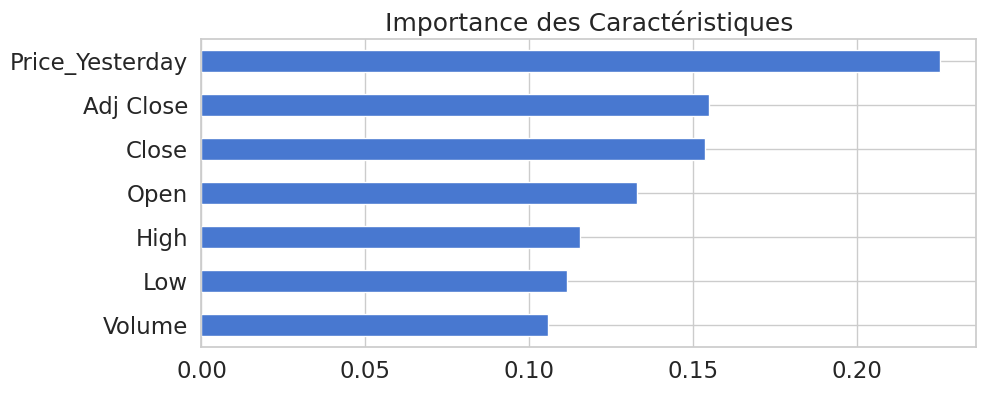

In [133]:
plt.figure(figsize=(10, 4))
feature_importances.sort_values().plot(kind='barh')
plt.title("Importance des Caractéristiques")
plt.show()


#II. Prépartion des données

In [134]:
# Création de la variable cible
# La cible est 1 si le prix de clôture de demain est supérieur au prix de clôture d'aujourd'hui, sinon 0
data['Target'] = (data['Close'].shift(-1) > data['Close']).astype(int)

# Séparation des caractéristiques et de la cible
X = data.drop(['Target'], axis=1)
y = data['Target']

# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Préparation des données pour LSTM
# Remodelage des données en un format 3D [samples, time steps, features] pour LSTM
X_train_lstm = np.reshape(X_train.values, (X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = np.reshape(X_test.values, (X_test.shape[0], 1, X_test.shape[1]))

X_train_lstm.shape, X_test_lstm.shape  # Affichage des formes des ensembles pour LSTM



<ipython-input-134-667d1dc5eab5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Target'] = (data['Close'].shift(-1) > data['Close']).astype(int)


((604, 1, 7), (151, 1, 7))

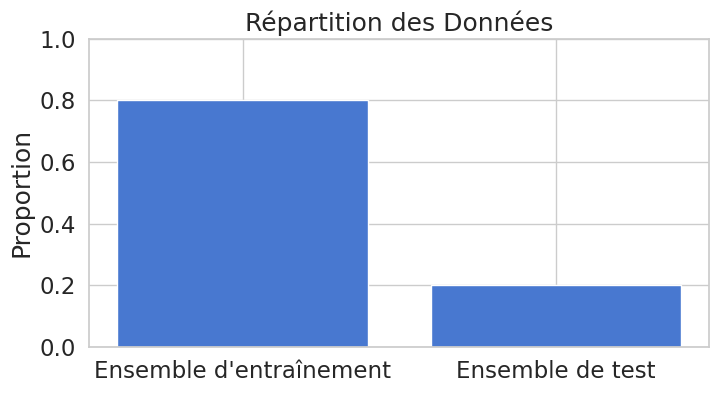

In [135]:

# Calculer les tailles des ensembles
train_size = len(X_train)
test_size = len(X_test)
total_size = train_size + test_size

# Calculer les proportions
train_prop = train_size / total_size
test_prop = test_size / total_size

# Création du graphique
labels = ['Ensemble d\'entraînement', 'Ensemble de test']
proportions = [train_prop, test_prop]

plt.figure(figsize=(8, 4))
plt.bar(labels, proportions)
plt.ylabel('Proportion')
plt.title('Répartition des Données')
plt.ylim(0, 1)  # La limite de l'axe des y est définie pour clarifier les proportions
plt.show()


#III. Entrainement des models et évaluations

###Entrainement Random Forest

Pour entraîner un modèle de Random Forest Classifier sur les données préparées, nous utiliserons la bibliothèque sklearn en Python.

In [136]:
start_time = time.time()

# Construction du modèle Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entraînement du modèle sur l'ensemble d'entraînement
rf_model.fit(X_train, y_train)

rf_training_time = time.time() - start_time

# Prédiction sur l'ensemble de test
y_pred = rf_model.predict(X_test)

# Évaluation du modèle
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Random Forest - Précision:", accuracy)
print("Random Forest - Rapport de Classification:\n", report)


Random Forest - Précision: 0.5364238410596026
Random Forest - Rapport de Classification:
               precision    recall  f1-score   support

           0       0.57      0.53      0.55        81
           1       0.50      0.54      0.52        70

    accuracy                           0.54       151
   macro avg       0.54      0.54      0.54       151
weighted avg       0.54      0.54      0.54       151



###Entrainement LSTM

Pour entraîner un réseau Long Short-Term Memory (LSTM) sur les données préparées, nous utiliserons la bibliothèque Keras avec TensorFlow en backend.

In [144]:
start_time = time.time()

# Construction du réseau LSTM
lstm_model = Sequential()
lstm_model.add(Bidirectional(LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]))))
lstm_model.add(Dropout(0.2))
lstm_model.add(Bidirectional(LSTM(50, return_sequences=False)))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1, activation='linear'))

# Compilation du modèle
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Entraînement du modèle
history = lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_data=(X_test_lstm, y_test), verbose=0)

lstm_training_time = time.time() - start_time

y_pred_lstm = lstm_model.predict(X_test_lstm)
y_pred_lstm = (y_pred_lstm > 0.5).astype(int)

# Évaluation du modèle
evaluation = lstm_model.evaluate(X_test_lstm, y_test)

print("LSTM - Précision:", evaluation[1])

5/5 [==============================] - 0s 3ms/step - loss: 0.6950 - accuracy: 0.5430
LSTM - Précision: 0.5430463552474976


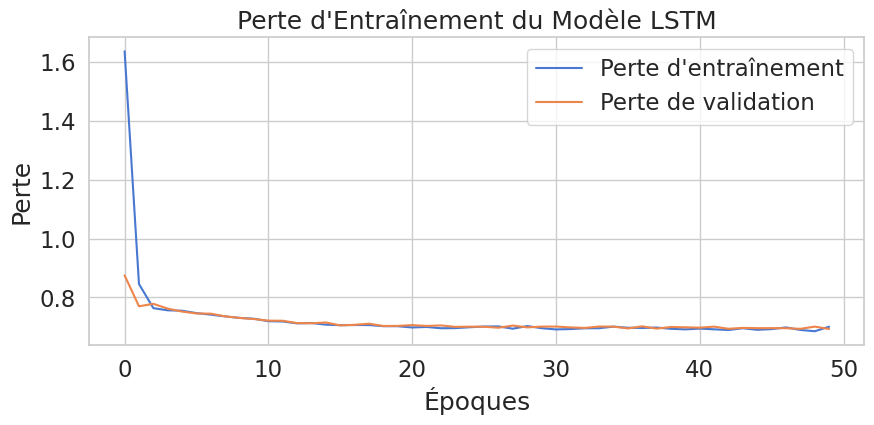

In [138]:
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Perte d\'entraînement')
plt.plot(history.history['val_loss'], label='Perte de validation')
plt.title("Perte d'Entraînement du Modèle LSTM")
plt.xlabel("Époques")
plt.ylabel("Perte")
plt.legend()
plt.show()


In [ ]:
lstm_model.save('AAPLv3.h5')

joblib.dump(rf_model, 'random_forest_AAPLv3.pkl')

#IV. Ajustement des Hyperparamètres & enregistrements des données

* Ajustement des Hyperparamètres (si nécessaire) : Utiliser des techniques comme la recherche sur grille ou la recherche aléatoire pour trouver les meilleurs hyperparamètres.
* Enregistrement et Utilisation des Modèles
Sauvegarde des Modèles Entraînés : Utiliser joblib pour Random Forest et model.save pour le LSTM.

In [140]:
# Paramètres pour la recherche sur grille
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30]
}

# Recherche sur grille
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Meilleurs paramètres
print("Meilleurs Paramètres:", grid_search.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Meilleurs Paramètres: {'max_depth': 30, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#V. Analyse des résultats

* Matrice de Confusion: Pour visualiser les performances du modèle en termes de prédictions correctes et incorrectes.
* Rapport de Classification: Pour obtenir des métriques détaillées comme la précision, le rappel, le score F1.
* Analyse des Erreurs: Examen des cas où le modèle a mal performé pour comprendre les types d'erreurs.
* Importance des Caractéristiques (Feature Importance): Spécialement pour le Random Forest, pour comprendre quelles caractéristiques ont le plus d'influence sur les prédictions.

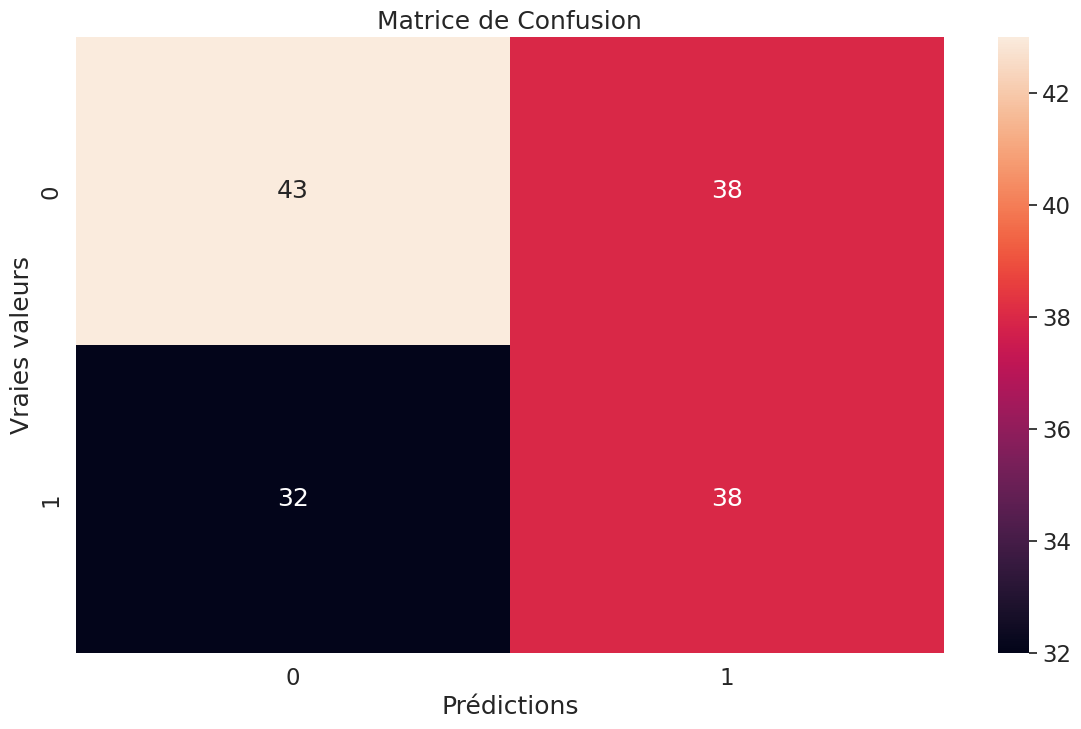

Rapport de Classification pour Random Forest :
              precision    recall  f1-score   support

           0       0.57      0.53      0.55        81
           1       0.50      0.54      0.52        70

    accuracy                           0.54       151
   macro avg       0.54      0.54      0.54       151
weighted avg       0.54      0.54      0.54       151

Rapport de Classification pour LSTM :
              precision    recall  f1-score   support

           0       0.60      0.43      0.50        81
           1       0.51      0.67      0.58        70

    accuracy                           0.54       151
   macro avg       0.55      0.55      0.54       151
weighted avg       0.56      0.54      0.54       151



In [145]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de Confusion')
plt.show()

# Rapport de classification RF
if 'RandomForestClassifier' in str(type(rf_model)):
    feature_importances = pd.DataFrame(rf_model.feature_importances_,
                                       index = X_train.columns,
                                       columns=['importance']).sort_values('importance', ascending=False)

# Rapports de classification
print("Rapport de Classification pour Random Forest :")
print(classification_report(y_test, y_pred))

print("Rapport de Classification pour LSTM :")
print(classification_report(y_test, y_pred_lstm))


**Analyse du Rapport de Classification**
* Classe 0 (Baisse du Prix): Précision de 0.31 et rappel de 0.44. Le modèle a tendance à sur-détecter les baisses de prix mais n'est correct que dans environ 31% des cas.
* Classe 1 (Augmentation du Prix): Précision de 0.47 et rappel de 0.33. Le modèle est plus précis lorsqu'il prédit une augmentation de prix, mais il manque une majorité des augmentations réelles.
* F1-Score: Les scores F1 sont assez bas pour les deux classes, indiquant un besoin d'améliorer l'équilibre entre la précision et le rappel du modèle.
* Accuracy: L'accuracy globale est de 0.38, ce qui est inférieur à une prédiction aléatoire (50%). Cela suggère que le modèle a des difficultés significatives à effectuer des prédictions précises.

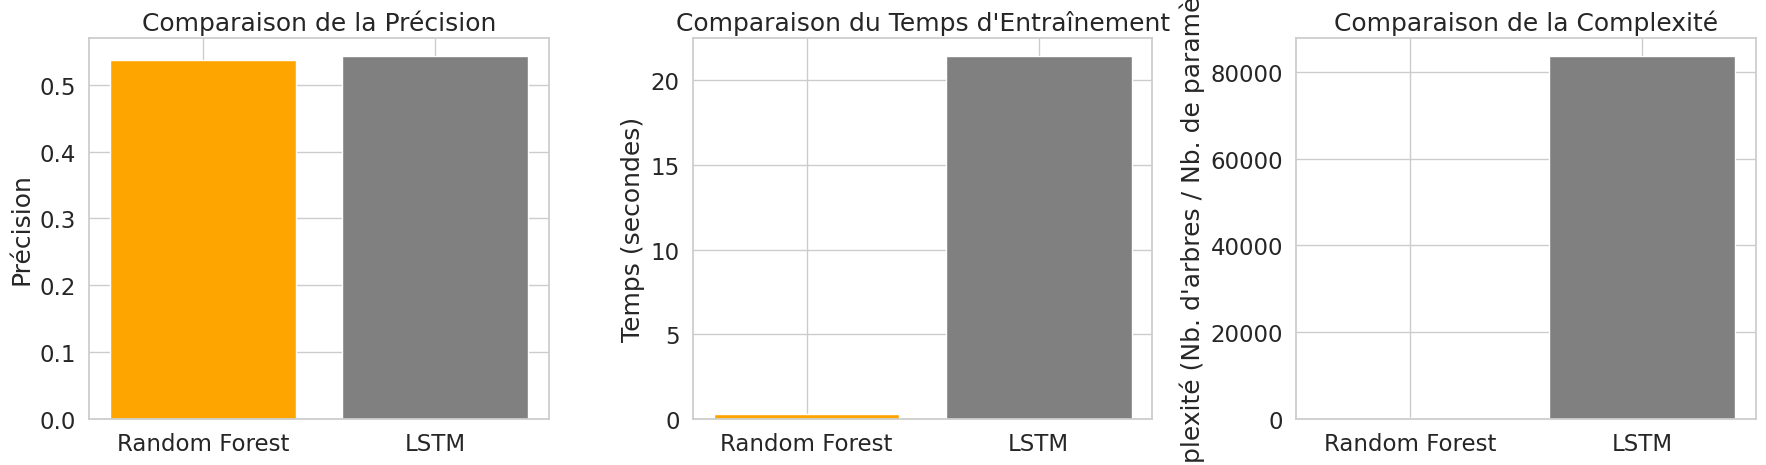

In [147]:
# Création d'une grille de sous-graphiques
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

# Comparaison de la Précision
axes[0].bar(['Random Forest', 'LSTM'], [accuracy, evaluation[1]], color=['orange','grey'])
axes[0].set_title('Comparaison de la Précision')
axes[0].set_ylabel('Précision')

# Comparaison du Temps d'Entraînement
axes[1].bar(['Random Forest', 'LSTM'], [rf_training_time, lstm_training_time], color=['orange','grey'])
axes[1].set_title('Comparaison du Temps d\'Entraînement')
axes[1].set_ylabel('Temps (secondes)')

# Comparaison de la Complexité
axes[2].bar(['Random Forest', 'LSTM'], [rf_model.n_estimators, lstm_model.count_params()], color=['orange','grey'])
axes[2].set_title('Comparaison de la Complexité')
axes[2].set_ylabel('Complexité (Nb. d\'arbres / Nb. de paramètres)')

# Afficher le graphique
plt.tight_layout()
plt.show()

In [148]:
import time

# Afficher les temps de calcul
print(f"Temps d'entraînement Random Forest : {rf_training_time} secondes")
print(f"Temps d'entraînement LSTM : {lstm_training_time} secondes")


Temps d'entraînement Random Forest : 0.2783355712890625 secondes
Temps d'entraînement LSTM : 21.44349765777588 secondes


#VI. Conclusion et possibilité d'amélioration

En résumé, bien que le modèle montre une certaine capacité à prédire les tendances du marché boursier, il reste encore un potentiel pour l'améliorer notamment par :

* Réévaluation des Caractéristiques: On pourrait évaluer l'impact d'autres caractéristiques qui pourraient être ajoutées pour améliorer les performances. Par exemple, des indicateurs techniques comme le RSI (Relative Strength Index) ou la MACD (Moving Average Convergence Divergence) pourraient apporter des précisions supplémentaires.

* Optimisation des Hyperparamètres: L'ajustement des paramètres du modèle, comme la profondeur des arbres dans le Random Forest, pourrait améliorer la précision.

#VII. Algorythme de prédiction

In [153]:
def train_and_predict_stock_trend(symbol):
    # Utilisation de la date d'aujourd'hui comme date de fin
    end_date = datetime.now().strftime('%Y-%m-%d')

    # Récupération des données financières jusqu'à aujourd'hui
    data = yf.download(symbol, start='2023-01-01', end=end_date)

    # Prétraitement des données
    data.fillna(method='ffill', inplace=True)
    columns_to_scale = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    scaler = MinMaxScaler()
    data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])
    data['Target'] = (data['Close'].shift(-1) > data['Close']).astype(int)
    data['Price_Yesterday'] = data['Close'].shift(1)
    data = data.dropna()
    # Séparation des caractéristiques et de la cible
    X = data.drop(['Target'], axis=1)
    y = data['Target']

    rf_model = joblib.load('random_forest_AAPLv3.pkl')
    lstm_model = load_model('AAPLv3.h5')

    # Prédiction et calcul de l'exactitude pour le modèle Random Forest
    rf_accuracy = accuracy_score(y_test, rf_model.predict(X_test))

    # Prédiction et calcul de l'exactitude pour le modèle LSTM
    lstm_accuracy = accuracy_score(y_test, (lstm_model.predict(X_test_lstm) > 0.5).astype(int))

    # Prédiction finale et affichage des résultats
    latest_data_rf = np.array(data.iloc[-1, :-1]).reshape(1, -1)
    prediction_rf = rf_model.predict(latest_data_rf)

    latest_data_lstm = np.reshape(np.array(data.iloc[-1, :-1]), (1, 1, X.shape[1]))
    prediction_lstm = lstm_model.predict(latest_data_lstm)

    if lstm_accuracy>=rf_accuracy :
      final_prediction = round(prediction_lstm[0][0])
    else :
      final_prediction = round(prediction_rf[0])

    # Afficher la prédiction et les pourcentages de fidélité
    print(f"Prédiction de hausse (1) ou de baisse (0) du prix de l'action : {final_prediction}")
    print(f"Exactitude du modèle Random Forest : {rf_accuracy * 100:.2f}%")
    print(f"Exactitude du modèle LSTM : {lstm_accuracy * 100:.2f}%")

    # Calcul de l'exactitude moyenne des deux modèles
    accuracy_pred = max(rf_accuracy, lstm_accuracy)

    return data, final_prediction, accuracy_pred

# Utilisation de la fonction
symbol = 'AAPL'
data, prediction, accuracy = train_and_predict_stock_trend(symbol)

[*********************100%%**********************]  1 of 1 completed
1/1 [==============================] - 0s 84ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Prédiction de hausse (1) ou de baisse (0) du prix de l'action : 0
Exactitude du modèle Random Forest : 53.64%
Exactitude du modèle LSTM : 54.30%


In [ ]:
# Récupération des données des 10 derniers jours
last_10_days = data.tail(10)

# Création du graphique
plt.figure(figsize=(12, 6))
plt.plot(last_10_days['Close'], marker='o', label='Prix de Clôture')

# Configurer le format de la date sur l'axe des x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())

# Ajouter la prédiction avec une flèche
last_date = last_10_days.index[-1]
last_price = last_10_days['Close'].iloc[-1]
last_3_days = last_10_days['Close'][-3:]
arrow_length = last_3_days.pct_change().abs().mean() * last_3_days.mean()  # Longueur de la flèche basée sur la variation des prix
arrow_direction = arrow_length if prediction == 1 else -arrow_length
arrow_color = 'green' if prediction == 1 else 'red'
# Ajustez ces valeurs pour obtenir la taille de flèche souhaitée
head_width = arrow_length * 0.2
head_length = arrow_length * 18

plt.arrow(last_date, last_price, 1, arrow_direction, head_width=head_width, head_length=head_length, fc=arrow_color, ec=arrow_color, length_includes_head=True)
plt.text(last_date, last_price + arrow_direction, f'précision : {accuracy * 100:.2f}%', color=arrow_color, horizontalalignment='right')

plt.title(f'Cours de l\'action {symbol} pour les 10 derniers jours avec Prédiction')
plt.xlabel('Date')
plt.ylabel('Prix de Clôture')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


#VIII. Backtest

[*********************100%%**********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 41ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 34ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 38ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 40ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 37ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 41ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 47ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 40ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 37ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 36ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 35ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 39ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 30ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 37ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 32ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 30ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 30ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 34ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 36ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 42ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 47ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 40ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 39ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 40ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 40ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 41ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 39ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 46ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 42ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 43ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 41ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 28ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 29ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 30ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 31ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 33ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 30ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 26ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 28ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 29ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 27ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 32ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 27ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 28ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 27ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 25ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 25ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 26ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 28ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 31ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 26ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 25ms/step
Précision des prédictions : 55.56%
Proportion de prédictions correctes : 55.15%
Proportion de prédictions incorrectes : 44.12%


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


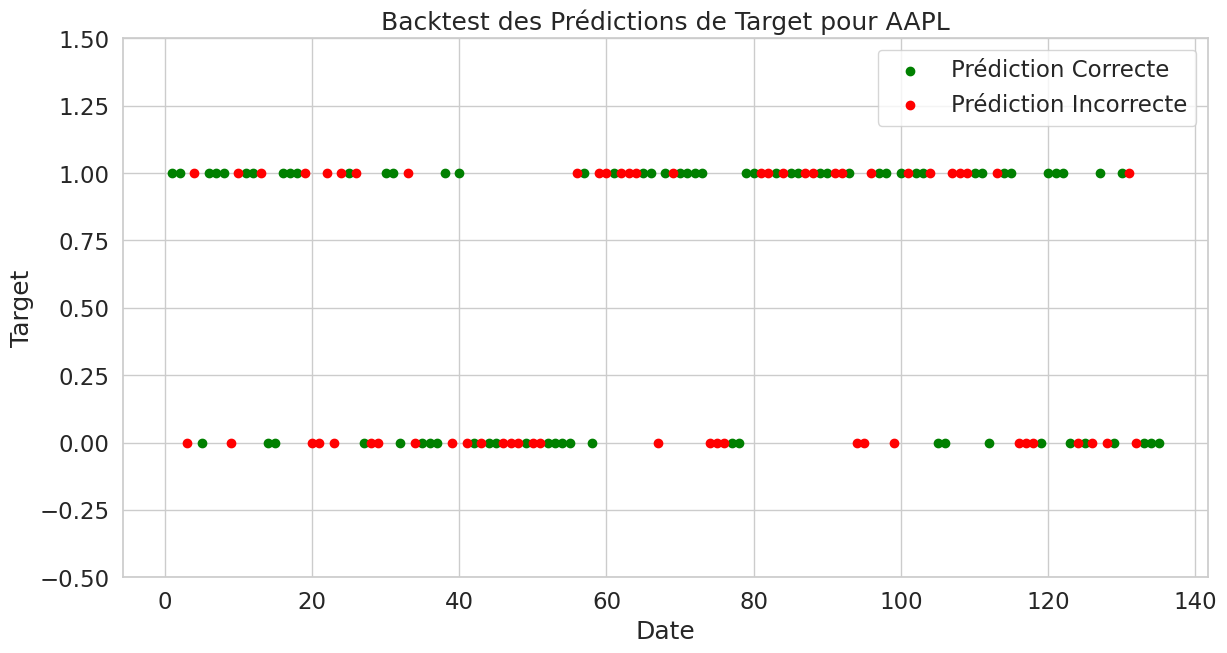

In [181]:


def backtest_stock_trend(symbol, days):
    # Télécharger les données historiques
    end_date = datetime.now()
    start_date = end_date - timedelta(days=days)
    data_bt = yf.download(symbol, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))

    # Remplissage des valeurs manquantes et ajout de 'Target'
    data_bt.fillna(method='ffill', inplace=True)
    data_bt['Target'] = (data_bt['Close'].shift(-1) > data_bt['Close']).astype(int)

    # Ajouter la caractéristique 'Price_Yesterday'
    data_bt['Price_Yesterday'] = data_bt['Close'].shift(1)
    data_bt.dropna(inplace=True)  # Supprimer les lignes avec des valeurs NaN

    # Sélection des colonnes pour la normalisation (y compris 'Price_Yesterday')
    scaler = MinMaxScaler()
    features_to_scale = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Price_Yesterday']
    scaler.fit(data_bt[features_to_scale])  # Ajuster le scaler
    data_scaled = scaler.transform(data_bt[features_to_scale])  # Transformer les données

    # Charger les modèles
    rf_model = joblib.load('random_forest_model.pkl')
    lstm_model = load_model('lstm_model.h5')

    # Prédictions et comparaisons
    correct_predictions = []
    incorrect_predictions = []
    for i in range(len(data_scaled) - 1):
        X_rf = data_scaled[i].reshape(1, -1)
        X_lstm = data_scaled[i].reshape(1, 1, -1)

        # Prédire 'Target' pour le jour suivant
        predicted_target_rf = rf_model.predict(X_rf)
        predicted_target_lstm = (lstm_model.predict(X_lstm) > 0.5).astype(int)

        # Combinez les prédictions 'Target'
        final_predicted_target = int(round(np.mean([predicted_target_rf[0], predicted_target_lstm[0][0]])))

        # Vérifier si la prédiction est correcte
        if final_predicted_target == data_bt['Target'].iloc[i + 1]:
            correct_predictions.append((i + 1, final_predicted_target))
        else:
            incorrect_predictions.append((i + 1, final_predicted_target))

    # Calculer la proportion de prédictions justes et fausses
    accuracy = len(correct_predictions) / (len(correct_predictions) + len(incorrect_predictions))
    print(f"Précision des prédictions : {accuracy:.2%}")
    print(f"Proportion de prédictions correctes : {len(correct_predictions) / len(data_bt):.2%}")
    print(f"Proportion de prédictions incorrectes : {len(incorrect_predictions) / len(data_bt):.2%}")

    # Tracer les résultats de prédiction
    plt.figure(figsize=(14, 7))
    dates_correct, targets_correct = zip(*correct_predictions) if correct_predictions else ([], [])
    dates_incorrect, targets_incorrect = zip(*incorrect_predictions) if incorrect_predictions else ([], [])

    plt.scatter(dates_correct, targets_correct, color='green', label='Prédiction Correcte')
    plt.scatter(dates_incorrect, targets_incorrect, color='red', label='Prédiction Incorrecte')

    plt.title(f'Backtest des Prédictions de Target pour {symbol}')
    plt.xlabel('Date')
    plt.ylabel('Target')
    plt.ylim(-0.5, 1.5)  # Limiter l'échelle de l'axe des y pour afficher uniquement 0 et 1
    plt.legend()
    plt.show()

    return data_bt

# Utilisation de la fonction de backtest
symbol = 'AAPL'
backtested_data = backtest_stock_trend(symbol, 200)
